# SIFT: Scale Invariant Feature Transform

Extract features that are invariant towards:
* image scale
* rotation

partially invariant towards:
* afine distortion
* changes in 3D viewpoint
* noise
* change in illumination

## Major steps of the algorithm

* __1.) Scale-space extrema detection:__ Search over all scales and image locations, efficient, using DoG, to identify potential interest points that are invariant to scale and orientation
* __2.) Keypoint localization:__ At each found candidate location, a more detailed model is extracted to determine location and scale.
* __3.) Orientation assignment:__ One or more orientations are assigned to each keypoint, based on local image gradient.
* __4.) Keypoint descriptor:__ local image gradient is measured at the selected scale and location. These are transformed into a representation.

In [1]:
# do all the import stuff
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2
import pandas
from scipy import signal, ndimage, misc

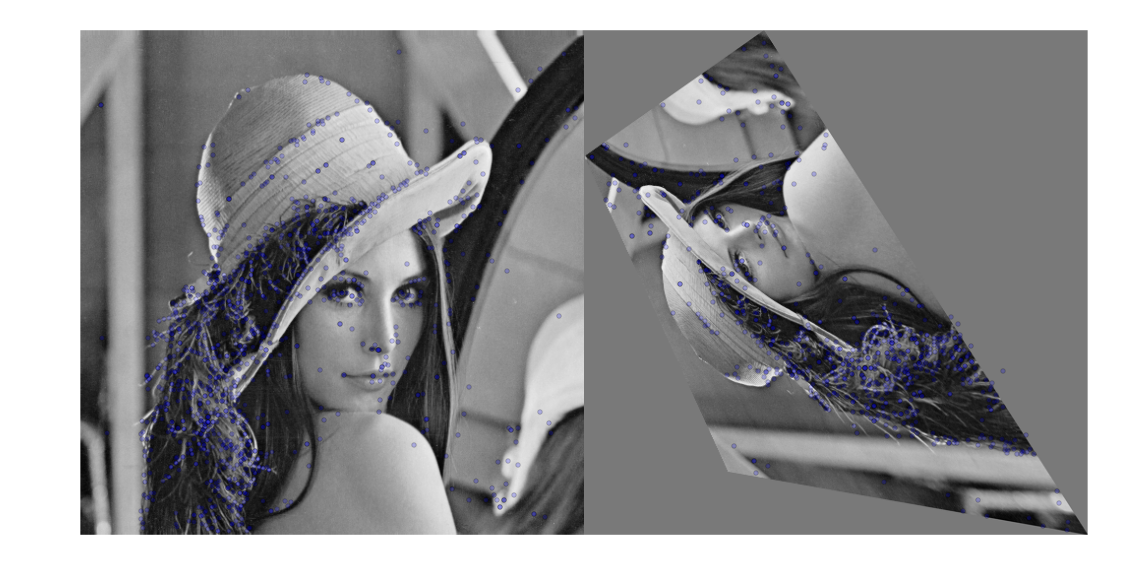

In [2]:
desc = pandas.read_csv("desc_Lenna.csv", header=None).as_matrix()
desc_trans = pandas.read_csv("desc_Lenna_transformed.csv", header=None).as_matrix()

locs = pandas.read_csv("locs_Lenna.csv", header=None).as_matrix() 
locs_trans = pandas.read_csv("locs_Lenna_transformed.csv", header=None).as_matrix()

I = cv2.imread('Lenna.png').astype(np.float32)/255.0
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

I_trans = cv2.imread('Lenna_transformed.png').astype(np.float32)/255.0
I_trans = cv2.cvtColor(I_trans, cv2.COLOR_BGR2GRAY)

I_comb = np.hstack((I, I_trans))


f, ax = plt.subplots(ncols=1)
f.set_size_inches(16, 16)

ax.imshow(I_comb, cmap=plt.get_cmap('gray'))

ax.scatter(locs[:, 1] + 0, locs[:, 0], alpha=.2)
ax.scatter(locs_trans[:, 1] + I.shape[1], locs_trans[:, 0], alpha=.2)


plt.axis("off")
plt.tight_layout()
plt.show()

## Detection of scale-space extrema

Detect keypoints by using a cascade filtering to identify candidate locations for further examination.
Identify locations and scales that can be repeatably assigned under different views of the same object. $\Rightarrow$ Detect locations that are invariant to scale change can be accomplished by searching for stable features accross all possible scales, using a continuous function of scale known as scale space.

The only possible scale-space kernel is the Gaussian function $G$ (WHY?),
therefor the scale space of an image is defined as:

$$ L(x,y,\sigma) = G(x,y,\sigma)*I(x,y)$$

where $*$ is the convolution in $x$ and $y$ and

$$G(x,y,\sigma)=\frac{1}{2\pi\sigma^2}e^{-(x^2+y^2)/2\sigma^2}$$.

To efficiently detect stable keypoints in scale space one can use scale-space extrema in the DoG function convolved with the image, $D(x,y,\sigma)$, where $k$ is a constant multiplicative factor:

$$D(x,y,\sigma)=(G(x,y,k\sigma)-G(x,y,\sigma))*I(x,y)=L(x,y,k\sigma)-L(x,y,\sigma)$$

Derivations:

$$ k = [1, -1] $$
$$ D_x = D*k $$
$$ D_y = D*k^T$$
$$ D_{xx} = D*k*k$$
$$ D_{yy} = D*k^T*k^T$$

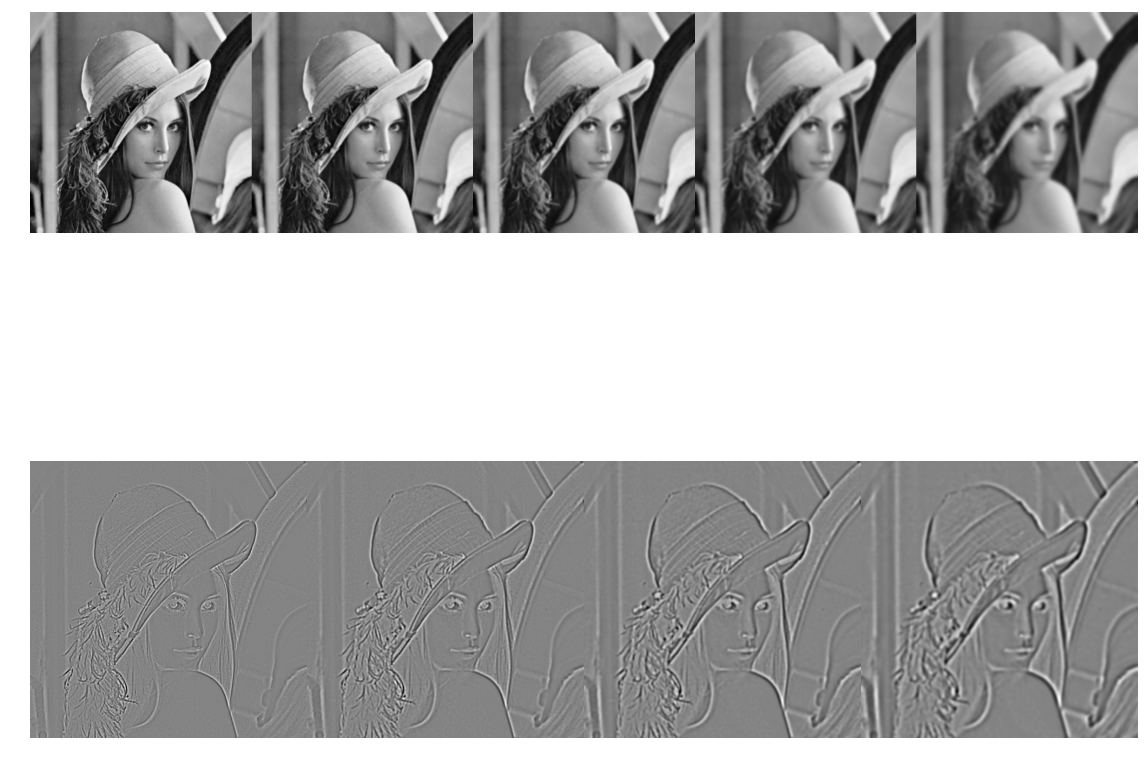

In [3]:
class Octave(object):
    S = 2
    _g = None
    _d = None
    
    DoG = []
    Gauss = []
    
    def __init__(self, I):
        scale = []
        k = 2**(1.0/ self.S)
        for i in range(0, self.S + 3):
            sigma = k ** i
            G = ndimage.filters.gaussian_filter(
                I, sigma, order=0, output=None,
                mode='reflect', cval=0.0, truncate=4.0)
            scale.append(G)
            self.Gauss.append(G)
            
        gaussian = []
        for i in range(0, self.S + 2):
            dog = scale[i+1] - scale[i]
            gaussian.append(dog)
            self.DoG.append(dog)
        
        self._d = np.hstack(gaussian)
        self._g = np.hstack(scale)

    def local_extrema(self):
        w = self.DoG[0].shape[1]
        h = self.DoG[0].shape[0]
        Max = np.zeros((h-2, w-2))
        Min = np.zeros((h-2, w-2))
        
        

octa = Octave(I)

f, (ax, ay) = plt.subplots(ncols=1, nrows=2)
f.set_size_inches(16, 16)

ax.imshow(octa._g, cmap=plt.get_cmap('gray'))
ay.imshow(octa._d, cmap=plt.get_cmap('gray'))

ay.axis("off")
ax.axis('off')
plt.tight_layout()
plt.show()

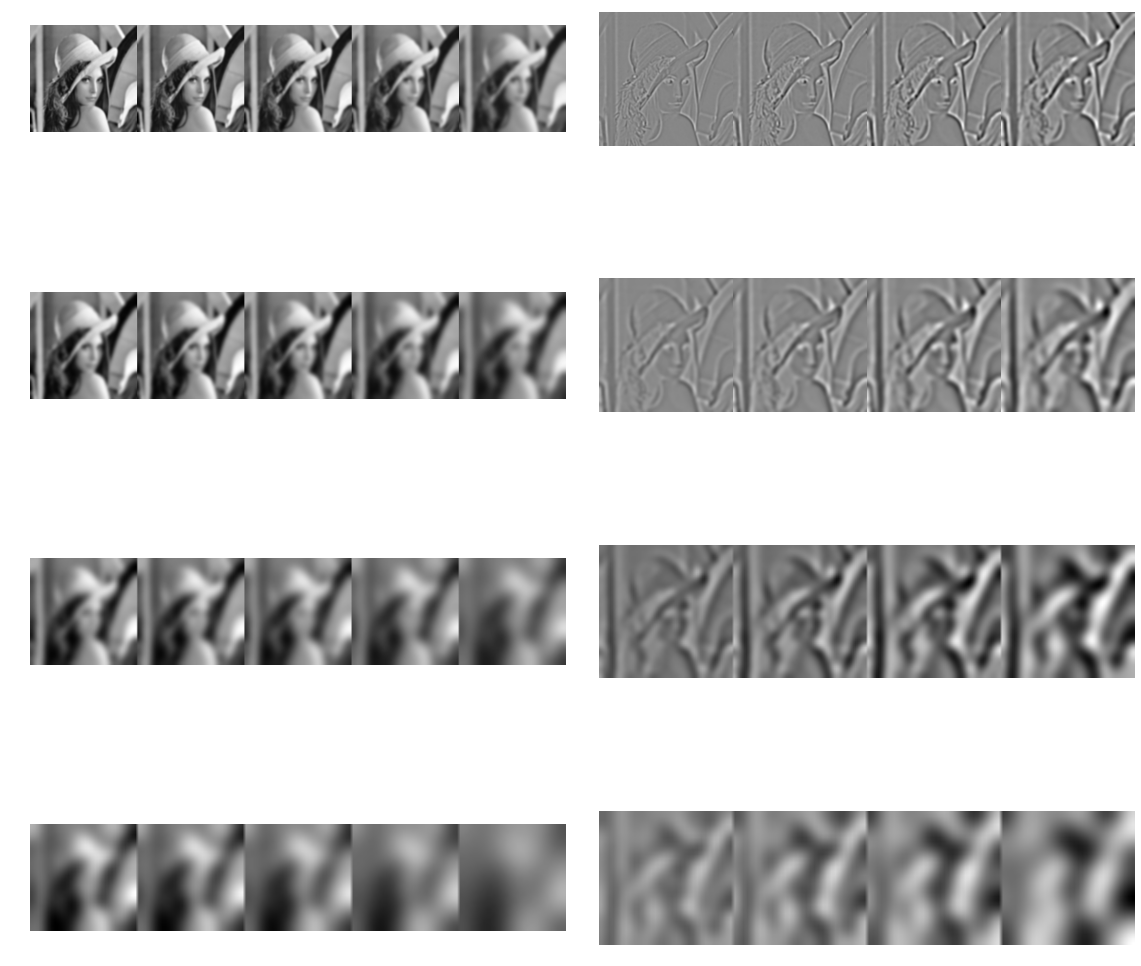

In [4]:
# Scale space
class ScaleSpace(object):
    octaves = []
    
    def __init__(self, I):
        Im = I.copy()
        octave = Octave(Im)
        while Im.shape[0] > 32:
            Im = octave.Gauss[-2]
            Im = misc.imresize(Im, 0.5).astype(np.float32) / 255.0
            octave = Octave(Im)
            self.octaves.append(octave)
            
    def draw(self):
        f, axs = plt.subplots(ncols=2, nrows=len(self.octaves))
        f.set_size_inches(16, 16)
        
        for i in range(len(self.octaves)):
            octa = self.octaves[i]
            axs[i][0].imshow(octa._g, cmap=plt.get_cmap('gray'))
            axs[i][1].imshow(octa._d, cmap=plt.get_cmap('gray'))
            axs[i][0].axis('off')
            axs[i][1].axis('off')

        plt.tight_layout()
        plt.show()
            
ss = ScaleSpace(I)
ss.draw()

In [15]:
# Local extrema detection